# Классификация эмоций на русском

In [ ]:
# Импорт основных библиотек
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer
from transformers import EarlyStoppingCallback
from transformers.pipelines.pt_utils import KeyDataset
import evaluate
from tqdm.auto import tqdm

In [ ]:
# Заранее перенесем все обучение на gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Загрузка и анализ данных
Используем для нашего классификатора эмоций англоязычный датасет GoEmotions. В нем один текст может иметь несколько меток, то есть задача мультилейбл-классификации

In [ ]:
print("Loading Dataset:")
dataset = load_dataset("go_emotions")

Loading Dataset:


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Посмотрим на первые несколько строк датасета

In [ ]:
dataset["train"].to_pandas().head()


,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


Посмотрим на название всех классов

In [ ]:
labels_list = dataset['train'].features['labels'].feature.names
print(labels_list)

num_labels = len(labels_list)

# индекс → название класса и наоборот
id2label = {i: label for i, label in enumerate(labels_list)}
label2id = {label: i for i, label in enumerate(labels_list)}


['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## 2. Подготовка данных: Перевод на русский язык
Исходный датасет на английском, для адаптации под русскоязычный домен используем модель машинного перевода `Helsinki-NLP/opus-mt-en-ru`.
Перевод занимает время, поэтому будем обрабатывать данные по батчам

In [ ]:
# Модель для перевода EN -> RU
TRANSLATION_MODEL = "Helsinki-NLP/opus-mt-en-ru"
MAX_LENGTH_TRANSLATION = 512
BATCH_SIZE = 64
pipeline_device = 0 if torch.cuda.is_available() else -1

translator = pipeline(
    "translation",
    model=TRANSLATION_MODEL,
    device=pipeline_device,
    model_kwargs={"torch_dtype": torch.float16} if pipeline_device >= 0 else {} # FP16 ускоряет на GPU
)

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


In [ ]:
def translate_batch(batch):
    # Получаем список текстов из батча
    texts_to_translate = batch["text"]

    try:
        # Вызываем пайплайн-переводчик для списка текстов

        translations = translator(
            texts_to_translate,
            max_length=MAX_LENGTH_TRANSLATION,
            batch_size=len(texts_to_translate),
            truncation=True
        )
        #  берем поле с текстом перевода
        batch["text_ru"] = [t['translation_text'] for t in translations]

    except Exception as e:
        # В случае ошибки заполняем переводы пустыми строками,
        print(f"Ошибка: {e}. Заполняем пустотой.")
        batch["text_ru"] = [""] * len(texts_to_translate)

    # Возвращаем  батч с полем "text_ru"
    return batch


In [ ]:
from datasets import DatasetDict

print(f"Начинаем перевод при максимальной длине = {MAX_LENGTH_TRANSLATION}:")
translated_dataset_dict = DatasetDict()

for split_name, current_split in dataset.items():
    print(f"\n Перевод сплита: {split_name} с {len(current_split)} примеров")

    translations = []
    for out in tqdm(translator(KeyDataset(current_split, "text"),
                               batch_size=BATCH_SIZE,
                               max_length=MAX_LENGTH_TRANSLATION,
                               truncation=True),
                    total=len(current_split),
                    desc=f"Перевод {split_name}"):

        # Результат - список словарей, берем текст
        translations.append(out[0]['translation_text'])

    #  Добавление новой колонки в текущий сплит
    split_with_translation = current_split.add_column("text_ru", translations)

    # Результат в новый словарь
    translated_dataset_dict[split_name] = split_with_translation
    print(f" Сплит {split_name} переведен")

# Сохраняем результат обратно в датасет
ru_dataset = translated_dataset_dict
print("\nПеревод выполнен")

Начинаем перевод при максимальной длине = 512:

 Перевод сплита: train с 43410 примеров


Перевод train:   0%|          | 0/43410 [00:00<?, ?it/s]

 Сплит train переведен

 Перевод сплита: validation с 5426 примеров


Перевод validation:   0%|          | 0/5426 [00:00<?, ?it/s]

 Сплит validation переведен

 Перевод сплита: test с 5427 примеров


Перевод test:   0%|          | 0/5427 [00:00<?, ?it/s]

 Сплит test переведен

Перевод выполнен


In [ ]:
print(f"Пример перевода: {ru_dataset['train'][0]['text']} -> {ru_dataset['train'][0]['text_ru']}")

Пример перевода: My favourite food is anything I didn't have to cook myself. -> Моя любимая еда - это то, что мне не нужно было готовить самому.


Избавимся от оригинального текста, оставив только перевод, а также объединим валидацию и тест

In [ ]:
ru_dataset = ru_dataset.remove_columns("text")

combined_test_set = concatenate_datasets([ru_dataset["validation"], ru_dataset["test"]])
ru_dataset["test"] = combined_test_set
ru_dataset.pop("validation")

Dataset({
    features: ['labels', 'id', 'text_ru'],
    num_rows: 5426
})

## 3. Анализ датасета
Посчитаем распределение эмоций. Это критически важно для выбора функции потерь.

Переведем список меток в multihot вектор, а также проврим дисбаланс классов

In [ ]:
def labels_to_multihot(batch):
    multi_hot = []
    for lab in batch["labels"]:
        mh = np.zeros(num_labels, dtype=np.int8)
        for idx in lab:
            mh[idx] = 1
        multi_hot.append(mh.tolist())
    batch["labels"] = multi_hot
    return batch

ru_dataset = ru_dataset.map(labels_to_multihot, batched=True)

In [ ]:
# Собираем все метки в массив
all_labels = np.array([example["labels"] for example in ru_dataset["train"]])

# Считаем количество положительных для каждой метки
label_counts = all_labels.sum(axis=0)

# Доля положительных примеров
label_ratios = label_counts / len(all_labels)

label_stats = pd.DataFrame({
    "label": [id2label[i] for i in range(len(label_counts))],
    "count": label_counts,
    "ratio": label_ratios
}).sort_values("ratio")
print(label_stats)

# веса обратно пропорциональны частоте метки
pos_weight = torch.tensor(1.0 / np.sqrt(label_ratios + 1e-6), dtype=torch.float).to(device)
loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)


             label  count     ratio
16           grief     77  0.001774
21           pride    111  0.002557
23          relief    153  0.003525
19     nervousness    164  0.003778
12   embarrassment    303  0.006980
24         remorse    545  0.012555
14            fear    596  0.013730
8           desire    641  0.014766
11         disgust    793  0.018268
13      excitement    853  0.019650
26        surprise   1060  0.024418
5           caring   1087  0.025040
22     realization   1110  0.025570
9   disappointment   1269  0.029233
25         sadness   1326  0.030546
6        confusion   1368  0.031513
17             joy   1452  0.033449
2            anger   1567  0.036098
20        optimism   1581  0.036420
10     disapproval   2022  0.046579
18            love   2086  0.048053
7        curiosity   2191  0.050472
1        amusement   2328  0.053628
3        annoyance   2470  0.056899
15       gratitude   2662  0.061322
4         approval   2939  0.067703
0       admiration   4130  0

Как можнно увидеть имеет место очень сильный дисбаланс классов, например, данных, у которых есть класс admiration почти в 54 раза больше, чем данных с grief. А большинство эмоций являются нейтральными, что также будет усложнять обучение модели. pos_weight заставит модель сильнее наказывать ошибки по редким классам, компенсируя дисбаланс. Редкие эмоции  будут весеть больше, и модель не будет предсказывать только частые эмоции

## 4. Токенизация и создание модели
Используем `cointegrated/rubert-tiny2` — это быстрая модель, эффективная для русского языка. Задача: **Multi-label classification**, то есть выходной слой равен количеству эмоций

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

MODEL_NAME = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_tokens(examples):
    return tokenizer(examples["text_ru"], truncation=True, max_length=512)

tokenized_dataset = ru_dataset.map(preprocess_tokens, batched=True)

# опредление модели

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels)
config.problem_type = "multi_label_classification"
config.id2label = id2label
config.label2id = label2id
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config).to(device)



Map:   0%|          | 0/10853 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Сделаем кастомный Trainer, потому что стандартный Trainer из HuggingFace не умеет автоматически применять кастомный BCEWithLogitsLoss с pos_weight в multi-label задачах + свой DataCollator, потому что по умолчанию коллатор не знает, как правильно собрать multi-hot метки в тензор

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Убираем метки из input
        labels = inputs.pop("labels")

        # Прогоняем модель и получаем logits
        outputs = model(**inputs)
        logits = outputs.logits

        # Гарантируем, что pos_weight лежит там же, где и logits
        if loss_fn.pos_weight.device != logits.device:
             loss_fn.pos_weight = loss_fn.pos_weight.to(logits.device)

        # Считаем кастомный loss с дисбалансом
        loss = loss_fn(logits, labels)

        # Возвращаем loss и outputs
        return (loss, outputs) if return_outputs else loss


# Data Collator
class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        # Используем стандартный коллатор для обычных входов
        self.default_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def __call__(self, features):
        # Извлекаем метки отдельно
        labels = [feature["labels"] for feature in features]

        # Убираем метки из фичей
        batch_features = [
            {k: v for k, v in feature.items() if k != "labels"}
            for feature in features
        ]

        # Собираем обычную часть батча (input_ids, attention_mask)
        batch = self.default_collator(batch_features)

        # Превращаем multi-hot списки в тензор float
        batch["labels"] = torch.as_tensor(labels, dtype=torch.float)

        return batch


Используем метрику f1_macro, тк в multi-label задачах и при сильном дисбалансе он даёт честную оценку качества по каждому классу, а не доминируется частыми метками

In [ ]:
# Метрика для обучения (фиксированный порог 0.5)
from sklearn.metrics import f1_score

def compute_metrics_during_train(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)
    score = f1_score(labels, preds, average="macro")
    return {"f1_macro": score}

Обучим нашу модель

In [ ]:
training_args = TrainingArguments(
    output_dir="./ru_goemotions_bert",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer, # Замена tokenizer=tokenizer
    data_collator=MultiLabelDataCollator(tokenizer),
    compute_metrics=compute_metrics_during_train,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Рання остановка чтоб не было переобучения
)

print("Start train")
trainer.train()

Start train


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.390700,0.375277,0.195234
2,0.340500,0.336061,0.317528
3,0.308100,0.320348,0.363448
4,0.296800,0.315191,0.391040
5,0.281500,0.314343,0.385762
6,0.275000,0.316394,0.396822
7,0.262500,0.318751,0.392599
8,0.243600,0.319313,0.387932
9,0.245900,0.321663,0.387440


TrainOutput(global_step=12213, training_loss=0.3010084659707914, metrics={'train_runtime': 347.4541, 'train_samples_per_second': 1249.374, 'train_steps_per_second': 39.056, 'total_flos': 220852250488176.0, 'train_loss': 0.3010084659707914, 'epoch': 9.0})

## 5. Оптимизация порогов
Стандартный порог 0.5 не оптимален для несбалансированных классов.
Мы подберем индивидуальный порог (от 0.01 до 0.99) для каждой эмоции, максимизирующий F1-score на валидации

In [ ]:
import os
import json
import numpy as np
import torch
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

#  функция поиска порогов
def find_best_thresholds(model, dataset, batch_size=32):
    print("Ищем лучшие thresholds")
    model.eval()
    all_probs = []
    all_labels_arr = []

    # Оставляем только нужные колонки ---
    columns_to_keep = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.column_names:
        columns_to_keep.append('token_type_ids')

    # Создаем временный датасет только с цифрами
    eval_dataset = dataset.select_columns(columns_to_keep)

    # Используем коллэйтор
    collator = MultiLabelDataCollator(tokenizer)

    dataloader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=batch_size,
        collate_fn=collator
    )

    # Отключаем вычисление градиентов и смотрим предсказания
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"].cpu().numpy()

            if "token_type_ids" in batch:
                token_type_ids = batch["token_type_ids"].to(model.device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_labels_arr.append(labels)

    all_probs = np.vstack(all_probs)
    all_labels_arr = np.vstack(all_labels_arr)

    best_thresh = []
    # Перебор порогов
    print("Считаем оптимальные thresholds для каждого класса")
    for i in range(all_labels_arr.shape[1]):
        thresholds = np.linspace(0.01, 0.99, 99)
        f1s = [f1_score(all_labels_arr[:, i], (all_probs[:, i] > t).astype(int)) for t in thresholds]
        best_thresh.append(float(thresholds[np.argmax(f1s)]))

    return best_thresh

In [ ]:
# Считаем пороги на тестовой выборке
best_thresholds = find_best_thresholds(model, tokenized_dataset["test"])

print("\n" + "-"*35)
print(f"{'"Эмоция"':<20} | {'Порог'}")
print("-" * 35)

for i, thr in enumerate(best_thresholds):
    label_name = id2label[i]
    print(f"{label_name:<20} | {thr:.3f}")

print("-"*35 + "\n")

# Сохранение модели
SAVE_PATH = "./final_pt_model"
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Сохраняем пороги и маппинг
thresholds_path = os.path.join(SAVE_PATH, "thresholds.json")
with open(thresholds_path, "w") as f:
    json.dump({"thresholds": best_thresholds, "id2label": id2label}, f)

print(f"Модель и пороги успешно сохранены в {SAVE_PATH}")

Ищем лучшие thresholds


Evaluating:   0%|          | 0/340 [00:00<?, ?it/s]

Считаем оптимальные thresholds для каждого класса

-----------------------------------
"Эмоция"             | Порог
-----------------------------------
admiration           | 0.530
amusement            | 0.530
anger                | 0.630
annoyance            | 0.470
approval             | 0.470
caring               | 0.500
confusion            | 0.530
curiosity            | 0.530
desire               | 0.540
disappointment       | 0.490
disapproval          | 0.510
disgust              | 0.580
embarrassment        | 0.590
excitement           | 0.560
fear                 | 0.650
gratitude            | 0.740
grief                | 0.590
joy                  | 0.570
love                 | 0.610
nervousness          | 0.400
optimism             | 0.620
pride                | 0.360
realization          | 0.490
relief               | 0.360
remorse              | 0.680
sadness              | 0.700
surprise             | 0.590
neutral              | 0.420
-----------------------------------


## 7. Анализ результатов и инсайты
Сравненим F1-score со стандартным и подобранным порогом.  а также посмотрим свои тесты и проанализиурем результаты

In [ ]:
print("Результат")

# Получаем предсказания на тестовом наборе
raw_pred = trainer.predict(tokenized_dataset["test"])
logits = raw_pred.predictions
labels = raw_pred.label_ids

# Переводим логиты в вероятности
probs = 1 / (1 + np.exp(-logits))

# Считаем F1 со стандартным порогом 0.5
y_pred_default = (probs > 0.5).astype(int)
f1_default = f1_score(labels, y_pred_default, average="macro")

# Считаем F1 с (best_thresholds
y_pred_optimized = (probs > np.array(best_thresholds)).astype(int)
f1_optimized = f1_score(labels, y_pred_optimized, average="macro")

print(f"F1 Macro (стандартный порог 0.5): {f1_default:.4f}")
print(f"F1 Macro (индивидуальные пороги): {f1_optimized:.4f}")
print(f"--> Прирост качества: {f1_optimized - f1_default:.4f}")

Результат


F1 Macro (стандартный порог 0.5): 0.3968
F1 Macro (индивидуальные пороги): 0.4155
--> Прирост качества: 0.0187


Данный результат указывает, что все еще модель может страдать от дисбаланса, а также проблема может быть в собранных данных и их отнесении к классам. Стоит добаваить синтетических данных, а также сильнее бороться с дисбаласном классов

In [ ]:
def predict_emotion(text, model, tokenizer, thresholds, id2label):
    model.eval()
    # Токенизация
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        logits = model(**inputs).logits

    # Вероятности
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    thresholds = np.array(thresholds)

    # Фильтрация по индивидуальным порогам
    active_indices = np.where(probs > thresholds)[0]

    results = []
    for idx in active_indices:
        results.append({
            "emotion": id2label[idx],
            "probability": round(float(probs[idx]), 3),
            "threshold": round(thresholds[idx], 3)
        })

    # Сортируем по уверенности
    return sorted(results, key=lambda x: x['probability'], reverse=True)

Напишем наши примеры, а также добавим сложный случай с сарказмом

In [ ]:
test_phrases = [
    "Спасибо большое, мне это помогло", # Ожидаемый резульат: gratitude ,тк тут благодарность
    "Спасибо, конечно, за твою помощь, но она была ужасна", # Ожидаемый резульат: disapproval,тк тут через сарказм проявлено неоодобрение
    "Ну окей", # Ожидаемый резульат: neutral ,тк тут нейтральное предложение
    "Я чувствую себя подавленным и одиноким." # Ожидаемый резульат: sadness, тк тут грусть
]

for text in test_phrases:
    print(f"\nТекст: '{text}'")
    preds = predict_emotion(text, model, tokenizer, best_thresholds, id2label)
    if preds:
        for p in preds:
            print(f"{p['emotion']} (вероятность: {p['probability']}, порог: {p['threshold']})")
    else:
      print("Эмоции не ясны")



Текст: 'Спасибо большое, мне это помогло'
gratitude (вероятность: 0.975, порог: 0.74)

Текст: 'Спасибо, конечно, за твою помощь, но она была ужасна'
Эмоции не ясны

Текст: 'Ну окей'
neutral (вероятность: 0.862, порог: 0.42)

Текст: 'Я чувствую себя подавленным и одиноким.'
sadness (вероятность: 0.806, порог: 0.7)


3 из 4 результатов оказались верны, только сарказм не распознала. Несмотря на метрики это отличный результат

Проанализуем результаты на валидации
Classification report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Получаем предсказания
raw_predictions = trainer.predict(tokenized_dataset["test"])
logits = raw_predictions.predictions
true_labels = raw_predictions.label_ids

# Превращаем в вероятности
probs = 1 / (1 + np.exp(-logits))

# 3. Применяем найденные пороги
preds_binary = (probs > np.array(best_thresholds)).astype(int)

print("Classification report:")
target_names = [id2label[i] for i in range(num_labels)]

print(classification_report(true_labels, preds_binary, target_names=target_names, zero_division=0))

Classification report:
                precision    recall  f1-score   support

    admiration       0.56      0.62      0.59       992
     amusement       0.64      0.51      0.57       567
         anger       0.35      0.33      0.34       393
     annoyance       0.24      0.39      0.29       623
      approval       0.33      0.26      0.29       748
        caring       0.32      0.36      0.34       288
     confusion       0.26      0.36      0.30       305
     curiosity       0.42      0.66      0.51       532
        desire       0.41      0.40      0.41       160
disappointment       0.20      0.24      0.22       314
   disapproval       0.29      0.46      0.35       559
       disgust       0.30      0.35      0.33       220
 embarrassment       0.45      0.24      0.31        72
    excitement       0.34      0.25      0.29       199
          fear       0.54      0.56      0.55       168
     gratitude       0.90      0.67      0.76       710
         grief       0.6

Модель показывает себя очень хорошо при распознавании gratitude (высокая precision = 0.90) и love (хороший баланс precision = 0.68 и recall 0.72). Самые слабые классы relief и nervousness имеют очень низкие f1-scores и support, что указывает на то, что модель практически не способна их надежно идентифицировать. Причиной этого является сильный исходный дисбаланс классов, тк класс neutral сильно доминирует в данных и поглощает другие эмоции (recall = 0.78, precision = 0.51)

Посмотрим на графике какие эмоции модель предсказывает лучше, а какие хуже с отметкой среднего F1

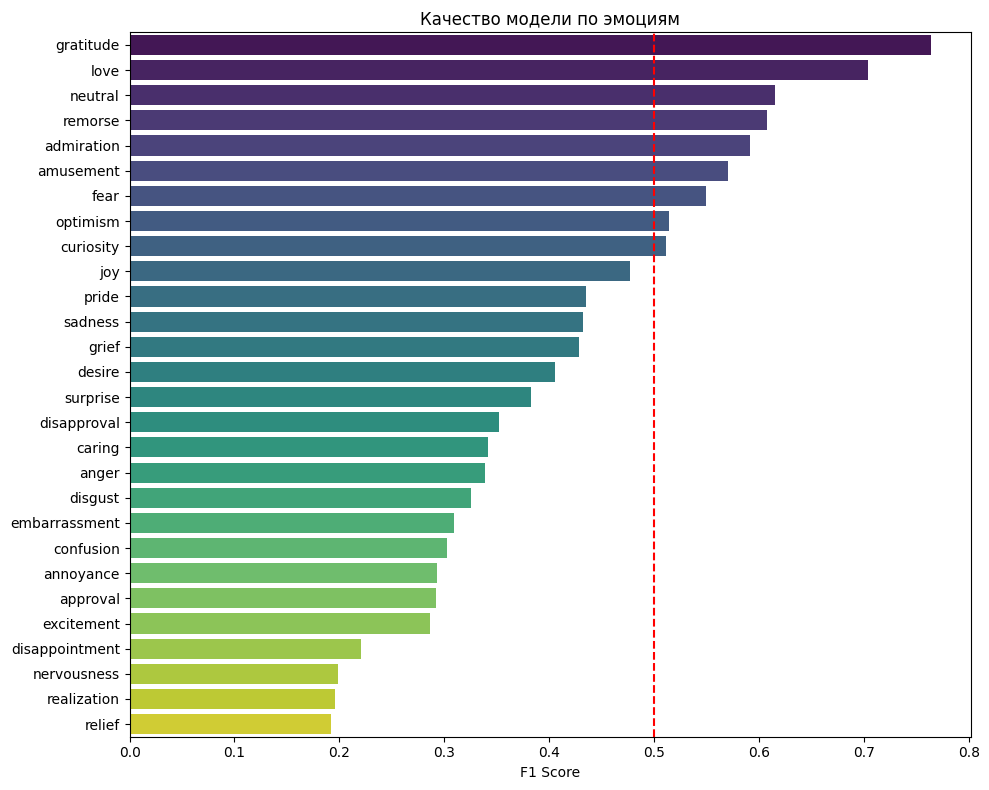

In [ ]:
# график качества эмоции относительно среднего
report_dict = classification_report(true_labels, preds_binary, target_names=target_names, output_dict=True, zero_division=0)
f1_scores = {label: report_dict[label]['f1-score'] for label in target_names}

# Сортируем
sorted_f1 = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 8))
sns.barplot(x=list(sorted_f1.values()), y=list(sorted_f1.keys()), hue=list(sorted_f1.keys()), palette="viridis", legend=False)
plt.title("Качество модели по эмоциям")
plt.xlabel("F1 Score")
plt.axvline(0.5, color='r', linestyle='--') #
plt.tight_layout()
plt.show()

Посмотрим на корреляцию классов

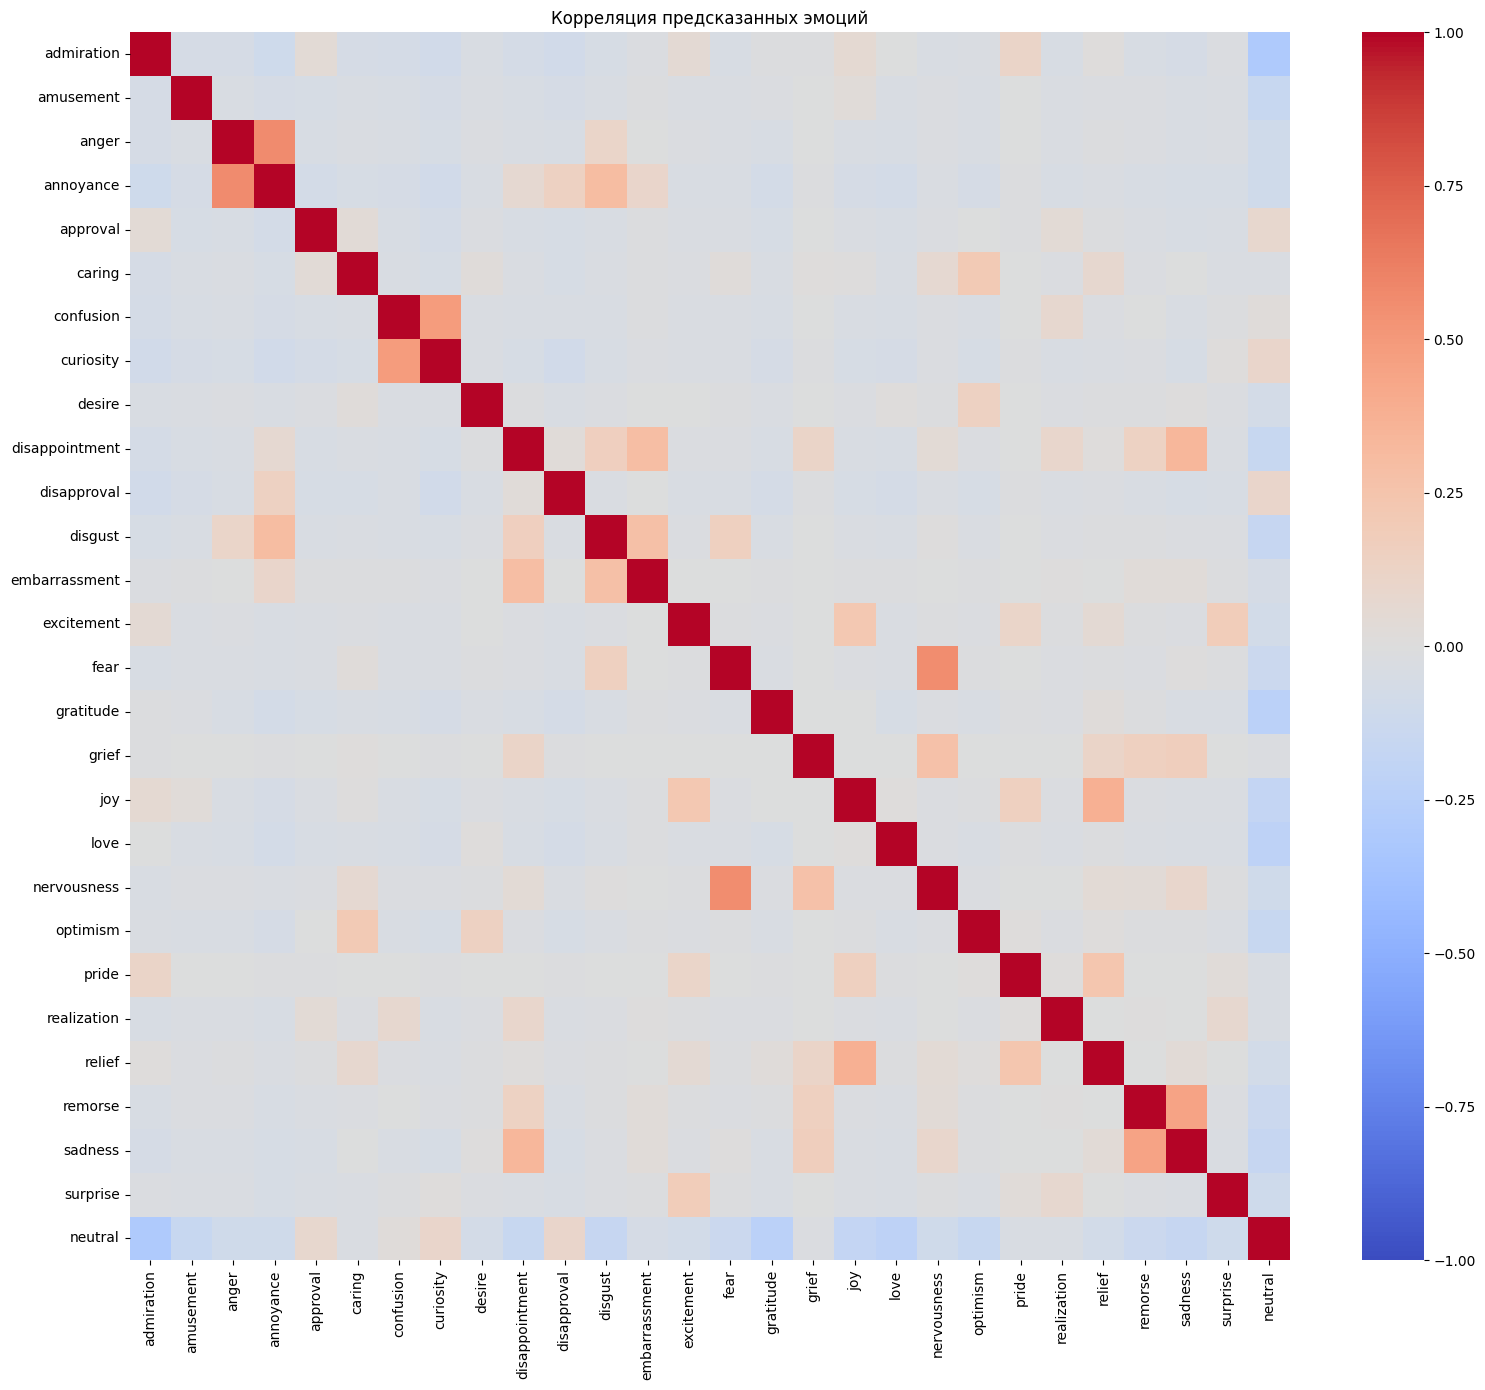

In [ ]:
# Считаем корреляцию предсказаний
# Это покажет, какие метки часто срабатывают вместе
correlation_matrix = np.corrcoef(preds_binary.T)

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, xticklabels=target_names, yticklabels=target_names, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляция предсказанных эмоций")
plt.tight_layout()
plt.show()

Как видим:

1. annoyance (раздражение) и disapproval (неодобрение) как отрицательные эмоции очень схожи для модели.
2. disappointment (разочарование) и sadness (грусть) - не всегда отличает огорчение от общей грусти.
3. anger (гнев) и disgust (отвращение) - сильные отрицательные эмоции часто смешиваются.
4. caring (забота) и love (любовь), то есть естественное смешение близких позитивных/теплых чувств.
5. excitement (возбуждение) и joy (радость) - эмоции высокого возбуждения часто путаются.
6. confusion (смущение) и curiosity (любопытство) познавательные/исследовательские состояния могут часто путаться.

То есть большинство из коррелирующих эмоций и реальный человек не всегда способен разделить, а Neutral коррелирует со многими эмоциями слабо. Это все показывает, что модель обучена неплохо, однако стоит дополнительно добавать overfitting классов, а также дополнительный сбор данных